In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft, rfftfreq
from matplotlib.colors import LogNorm
from itertools import combinations
import sys, os

parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
import telescope_1d
from scipy.stats import norm

In [2]:
# Initialize non-redundant telescope array
ndishes = 8
npix = 4096
redundant = False
seed = 0
t = telescope_1d.Telescope1D(Ndishes=ndishes, Npix_fft=npix, redundant=redundant, seed=seed)

# Generate sky (foregrounds; white noise in angle but frequncy independent)
sky = 1000*t.get_uniform_sky(high=2, seed=seed)
    
# Generate signal (white noise in both freqency and angle)
np.random.seed(seed)
signal = np.random.normal(0,1,(t.Nfreq,t.Npix))

# Convolve and convert image to uvplane
uvsky = t.observe_image(sky)
uvsig = t.observe_image(signal) 

# Get real space maps
rmap_sky = t.get_obs_rmap(uvsky, time_error_sigma=0, filter_FG=False)
rmap_sig = t.get_obs_rmap(uvsig, time_error_sigma=0, filter_FG=False)
rmap_skyf = t.get_obs_rmap(uvsky, time_error_sigma=0, filter_FG=True)
rmap_sigf = t.get_obs_rmap(uvsig, time_error_sigma=0, filter_FG=True)
rmap_sky_error = t.get_obs_rmap(uvsky, time_error_sigma=10e-12, filter_FG=False)
rmap_sig_error = t.get_obs_rmap(uvsig, time_error_sigma=10e-12, filter_FG=False)
rmap_skyf_error = t.get_obs_rmap(uvsky, time_error_sigma=10e-12, filter_FG=True)
rmap_sigf_error = t.get_obs_rmap(uvsig, time_error_sigma=10e-12, filter_FG=True)

# Power spectra of foregrounds, filtered foregrounds, signal, filtered signal
(ps_sky, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sky, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_sig, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sig, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_skyf, k_modes, alpha_binned) = t.get_rmap_ps(rmap_skyf, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_sigf, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sigf, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_sky_error, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sky_error, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_sig_error, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sig_error, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_skyf_error, k_modes, alpha_binned) = t.get_rmap_ps(rmap_skyf_error, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_sigf_error, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sigf_error, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)

Filtered 300 modes.
Filtered 300 modes.
Filtered 300 modes.
Filtered 300 modes.


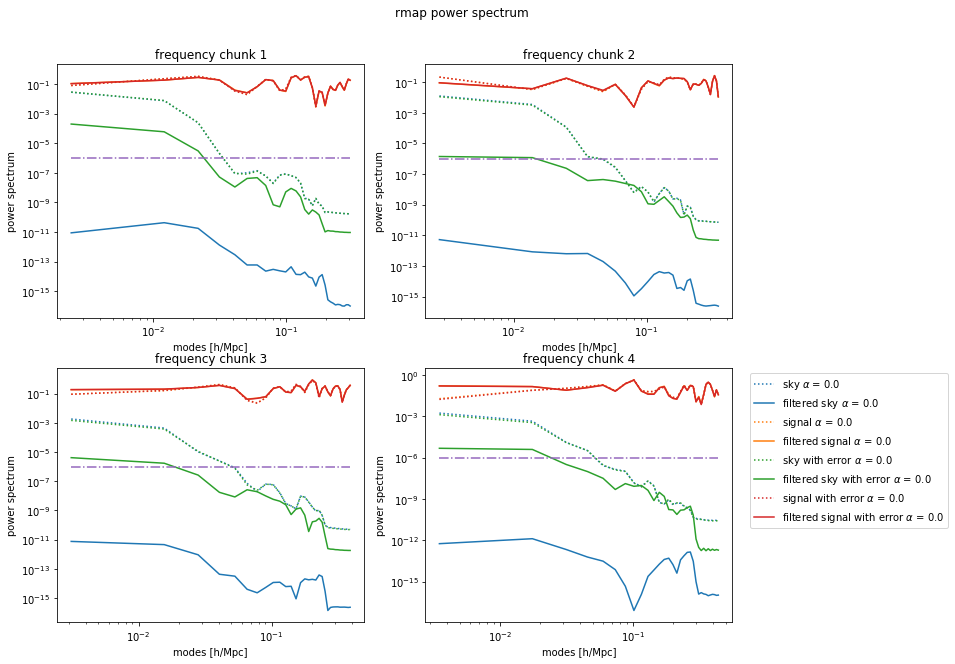

In [3]:
# Plot
Nfreqchunks = 4
alpha_idx_no_source = [t.Npix//2]
fig = plt.figure(figsize=(15,10))
for i in range(Nfreqchunks):
    max_sky = np.max(ps_sky[i])
    max_sig = np.max(ps_sig[i])
    max_sky_error = np.max(ps_sky_error[i])
    max_sig_error = np.max(ps_sig_error[i])
    plt.subplot(2,Nfreqchunks//2,i+1)
    modes = k_modes[i]
    m = t.alpha.shape[0]//alpha_binned.shape[0]
    ax = plt.gca()
    for a in alpha_idx_no_source:
        alpha_idx_binned = a//m
        alpha = t.alpha[a]
        # Without error
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_sky[i][:,alpha_idx_binned]/max_sky,
                   linestyle=':', color=color, label=fr'sky $\alpha$ = {alpha}')
        plt.loglog(modes, ps_skyf[i][:,alpha_idx_binned]/max_sky,
                   linestyle='-', color=color, label=fr'filtered sky $\alpha$ = {alpha}')
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_sig[i][:,alpha_idx_binned]/max_sig,
                   linestyle=':', color=color, label=fr'signal $\alpha$ = {alpha}')
        plt.loglog(modes, ps_sigf[i][:,alpha_idx_binned]/max_sig,
                   linestyle='-', color=color, label=fr'filtered signal $\alpha$ = {alpha}')
        # With error
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_sky_error[i][:,alpha_idx_binned]/max_sky_error,
                   linestyle=':', color=color, label=fr'sky with error $\alpha$ = {alpha}')
        plt.loglog(modes, ps_skyf_error[i][:,alpha_idx_binned]/max_sky_error,
                   linestyle='-', color=color, label=fr'filtered sky with error $\alpha$ = {alpha}')
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_sig_error[i][:,alpha_idx_binned]/max_sig_error,
                   linestyle=':', color=color, label=fr'signal with error $\alpha$ = {alpha}')
        plt.loglog(modes, ps_sigf_error[i][:,alpha_idx_binned]/max_sig_error,
                   linestyle='-', color=color, label=fr'filtered signal with error $\alpha$ = {alpha}')
    # Add line at 1e-6
    line = np.array([1e-6 for i in range(len(modes))])
    color = next(ax._get_lines.prop_cycler)['color']
    plt.loglog(modes, line, linestyle='-.', color=color)
    plt.xlabel('modes [h/Mpc]')
    plt.ylabel('power spectrum')
    #plt.ylim(1e-11, 1)
    plt.title('frequency chunk {}'.format(i+1))
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.9, right=0.75)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.suptitle('rmap power spectrum')
plt.show()

In [4]:
# Initialize redundant telescope array
ndishes = 8
npix = 4096
redundant = True
seed = 0
t = telescope_1d.Telescope1D(Ndishes=ndishes, Npix_fft=npix, redundant=redundant, seed=seed)

# Generate sky (foregrounds; white noise in angle but frequncy independent)
sky = 1000*t.get_uniform_sky(high=2, seed=seed)
    
# Generate signal (white noise in both freqency and angle)
np.random.seed(seed)
signal = np.random.normal(0,1,(t.Nfreq,t.Npix))

# Convolve and convert image to uvplane
uvsky = t.observe_image(sky)
uvsig = t.observe_image(signal) 

# Get real space maps
rmap_sky = t.get_obs_rmap(uvsky, time_error_sigma=0, filter_FG=False)
rmap_sig = t.get_obs_rmap(uvsig, time_error_sigma=0, filter_FG=False)
rmap_skyf = t.get_obs_rmap(uvsky, time_error_sigma=0, filter_FG=True)
rmap_sigf = t.get_obs_rmap(uvsig, time_error_sigma=0, filter_FG=True)
rmap_sky_error = t.get_obs_rmap(uvsky, time_error_sigma=10e-12, filter_FG=False)
rmap_sig_error = t.get_obs_rmap(uvsig, time_error_sigma=10e-12, filter_FG=False)
rmap_skyf_error = t.get_obs_rmap(uvsky, time_error_sigma=10e-12, filter_FG=True)
rmap_sigf_error = t.get_obs_rmap(uvsig, time_error_sigma=10e-12, filter_FG=True)

# Power spectra of foregrounds, filtered foregrounds, signal, filtered signal
(ps_sky, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sky, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_sig, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sig, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_skyf, k_modes, alpha_binned) = t.get_rmap_ps(rmap_skyf, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_sigf, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sigf, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_sky_error, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sky_error, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_sig_error, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sig_error, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_skyf_error, k_modes, alpha_binned) = t.get_rmap_ps(rmap_skyf_error, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_sigf_error, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sigf_error, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)

Filtered 248 modes.
Filtered 248 modes.
Filtered 248 modes.
Filtered 248 modes.


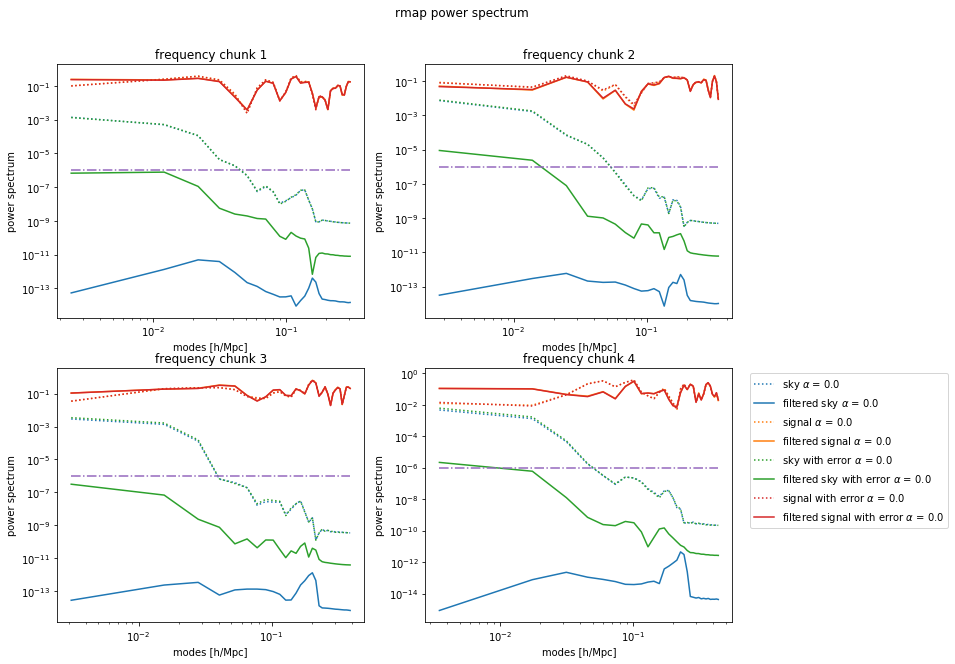

In [5]:
# Plot
Nfreqchunks = 4
alpha_idx_no_source = [t.Npix//2]
fig = plt.figure(figsize=(15,10))
for i in range(Nfreqchunks):
    max_sky = np.max(ps_sky[i])
    max_sig = np.max(ps_sig[i])
    max_sky_error = np.max(ps_sky_error[i])
    max_sig_error = np.max(ps_sig_error[i])
    plt.subplot(2,Nfreqchunks//2,i+1)
    modes = k_modes[i]
    m = t.alpha.shape[0]//alpha_binned.shape[0]
    ax = plt.gca()
    for a in alpha_idx_no_source:
        alpha_idx_binned = a//m
        alpha = t.alpha[a]
        # Without error
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_sky[i][:,alpha_idx_binned]/max_sky,
                   linestyle=':', color=color, label=fr'sky $\alpha$ = {alpha}')
        plt.loglog(modes, ps_skyf[i][:,alpha_idx_binned]/max_sky,
                   linestyle='-', color=color, label=fr'filtered sky $\alpha$ = {alpha}')
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_sig[i][:,alpha_idx_binned]/max_sig,
                   linestyle=':', color=color, label=fr'signal $\alpha$ = {alpha}')
        plt.loglog(modes, ps_sigf[i][:,alpha_idx_binned]/max_sig,
                   linestyle='-', color=color, label=fr'filtered signal $\alpha$ = {alpha}')
        # With error
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_sky_error[i][:,alpha_idx_binned]/max_sky_error,
                   linestyle=':', color=color, label=fr'sky with error $\alpha$ = {alpha}')
        plt.loglog(modes, ps_skyf_error[i][:,alpha_idx_binned]/max_sky_error,
                   linestyle='-', color=color, label=fr'filtered sky with error $\alpha$ = {alpha}')
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_sig_error[i][:,alpha_idx_binned]/max_sig_error,
                   linestyle=':', color=color, label=fr'signal with error $\alpha$ = {alpha}')
        plt.loglog(modes, ps_sigf_error[i][:,alpha_idx_binned]/max_sig_error,
                   linestyle='-', color=color, label=fr'filtered signal with error $\alpha$ = {alpha}')
    # Add line at 1e-6
    line = np.array([1e-6 for i in range(len(modes))])
    color = next(ax._get_lines.prop_cycler)['color']
    plt.loglog(modes, line, linestyle='-.', color=color)
    plt.xlabel('modes [h/Mpc]')
    plt.ylabel('power spectrum')
    #plt.ylim(1e-11, 1)
    plt.title('frequency chunk {}'.format(i+1))
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.9, right=0.75)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.suptitle('rmap power spectrum')
plt.show()

In [6]:
# Try larger error, still using redundant array
rmap_sky_error_2 = t.get_obs_rmap(uvsky, time_error_sigma=100e-12, filter_FG=False)
rmap_sig_error_2 = t.get_obs_rmap(uvsig, time_error_sigma=100e-12, filter_FG=False)
rmap_skyf_error_2 = t.get_obs_rmap(uvsky, time_error_sigma=100e-12, filter_FG=True)
rmap_sigf_error_2 = t.get_obs_rmap(uvsig, time_error_sigma=100e-12, filter_FG=True)

# Power spectra of foregrounds, filtered foregrounds, signal, filtered signal
(ps_sky_error_2, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sky_error_2, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_sig_error_2, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sig_error_2, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_skyf_error_2, k_modes, alpha_binned) = t.get_rmap_ps(rmap_skyf_error_2, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)
(ps_sigf_error_2, k_modes, alpha_binned) = t.get_rmap_ps(rmap_sigf_error_2, Nfreqchunks=4, m_alpha=2, m_freq=2, padding=1, window_fn=np.blackman)

Filtered 248 modes.
Filtered 248 modes.


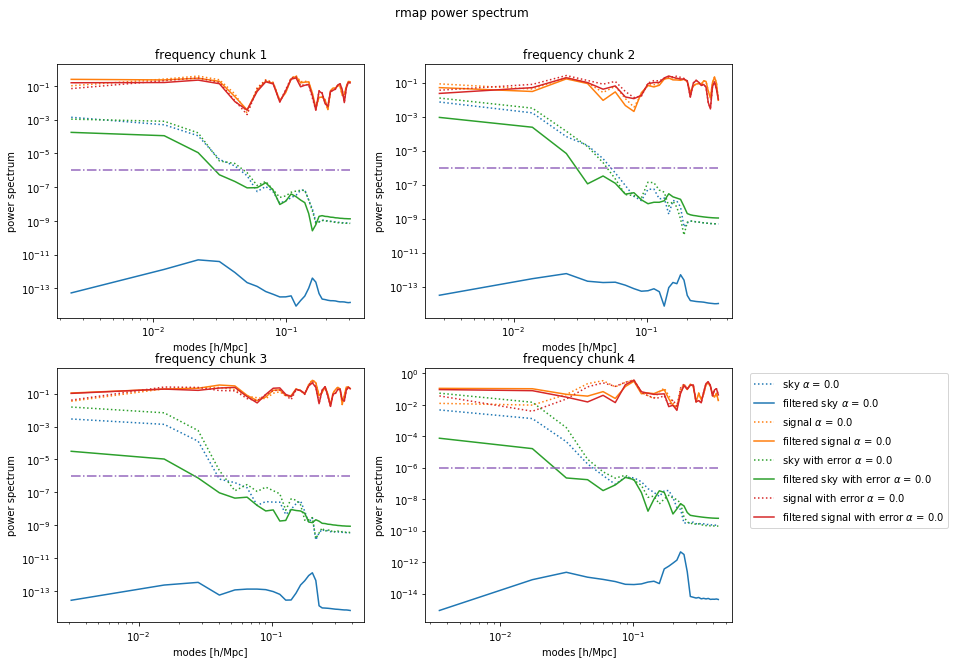

In [7]:
# Plot
Nfreqchunks = 4
alpha_idx_no_source = [t.Npix//2]
fig = plt.figure(figsize=(15,10))
for i in range(Nfreqchunks):
    max_sky = np.max(ps_sky[i])
    max_sig = np.max(ps_sig[i])
    max_sky_error = np.max(ps_sky_error_2[i])
    max_sig_error = np.max(ps_sig_error_2[i])
    plt.subplot(2,Nfreqchunks//2,i+1)
    modes = k_modes[i]
    m = t.alpha.shape[0]//alpha_binned.shape[0]
    ax = plt.gca()
    for a in alpha_idx_no_source:
        alpha_idx_binned = a//m
        alpha = t.alpha[a]
        # Without error
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_sky[i][:,alpha_idx_binned]/max_sky,
                   linestyle=':', color=color, label=fr'sky $\alpha$ = {alpha}')
        plt.loglog(modes, ps_skyf[i][:,alpha_idx_binned]/max_sky,
                   linestyle='-', color=color, label=fr'filtered sky $\alpha$ = {alpha}')
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_sig[i][:,alpha_idx_binned]/max_sig,
                   linestyle=':', color=color, label=fr'signal $\alpha$ = {alpha}')
        plt.loglog(modes, ps_sigf[i][:,alpha_idx_binned]/max_sig,
                   linestyle='-', color=color, label=fr'filtered signal $\alpha$ = {alpha}')
        # With error
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_sky_error_2[i][:,alpha_idx_binned]/max_sky_error,
                   linestyle=':', color=color, label=fr'sky with error $\alpha$ = {alpha}')
        plt.loglog(modes, ps_skyf_error_2[i][:,alpha_idx_binned]/max_sky_error,
                   linestyle='-', color=color, label=fr'filtered sky with error $\alpha$ = {alpha}')
        color = next(ax._get_lines.prop_cycler)['color']
        plt.loglog(modes, ps_sig_error_2[i][:,alpha_idx_binned]/max_sig_error,
                   linestyle=':', color=color, label=fr'signal with error $\alpha$ = {alpha}')
        plt.loglog(modes, ps_sigf_error_2[i][:,alpha_idx_binned]/max_sig_error,
                   linestyle='-', color=color, label=fr'filtered signal with error $\alpha$ = {alpha}')
    # Add line at 1e-6
    line = np.array([1e-6 for i in range(len(modes))])
    color = next(ax._get_lines.prop_cycler)['color']
    plt.loglog(modes, line, linestyle='-.', color=color)
    plt.xlabel('modes [h/Mpc]')
    plt.ylabel('power spectrum')
    #plt.ylim(1e-11, 1)
    plt.title('frequency chunk {}'.format(i+1))
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.9, right=0.75)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.suptitle('rmap power spectrum')
plt.show()